<a href="https://colab.research.google.com/github/CristinaMarsh/Learning_/blob/main/ODE/torchsde_Tutorials.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Thanks https://github.com/google-research/torchsde/blob/master/examples/demo.ipynb

In [72]:
! git clone https://github.com/google-research/torchsde.git

Cloning into 'torchsde'...
remote: Enumerating objects: 1592, done.
remote: Counting objects: 100% (162/162), done.
remote: Compressing objects: 100% (102/102), done.
remote: Total 1592 (delta 86), reused 109 (delta 55), pack-reused 1430
Receiving objects: 100% (1592/1592), 4.31 MiB | 16.17 MiB/s, done.
Resolving deltas: 100% (1090/1090), done.


This notebook is a short guide that covers issues of interest including:

* Defining and solving SDEs
* Gaining control over the randomness (path generation conditional on a Brownian motion sample)
* Different noise types of SDEs
* Gradient computation/backpropagation

In [2]:
! pip install torchsde

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 59 kB 6.3 MB/s 
     |████████████████████████████████| 193 kB 27.5 MB/s 
     |████████████████████████████████| 38.1 MB 1.2 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [3]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import torchsde

import torch
import torch.nn as nn

%matplotlib inline
import matplotlib.pyplot as plt

In [8]:

def plot(ts, samples, xlabel, ylabel, title=''):
    ts = ts.cpu()
    samples = samples.squeeze().t().cpu()
    plt.figure()
    for i, sample in enumerate(samples):
        plt.plot(ts, sample, marker='x', label=f'sample {i}')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()    

Just like how each ordinary differential equation (ODE) is governed by a vector field, a stochastic differential equation (SDE) is governed by two vector fields, which are called the drift and diffusion functions:
$$
d y(t)=\underbrace{f\left(t, y(t), \theta_{f}\right)}_{\text {drift }} d t+\underbrace{g\left(t, y(t), \theta_{g}\right)}_{\text {diffusion }} d W(t) .
$$
The output of $f$ is of the same size as the $d$-dimensional state, whereas the output of $g$ may be a matrix of size $(d, m)$. $W(t)$ is the Brownian motion (aka Wiener process), and it is $m$ dimensional. It is a stochastic process, and each random draw produces a function of time.
Note that the second term on the right hand side $g d W$ is based on matrix-vector products.

# 1. Solving a simple SDE
To implement an SDE, we create a class with the functions $f$ and $g$:

In [5]:
class SDE(nn.Module):

    def __init__(self):
      super().__init__()
      self.theta = nn.Parameter(torch.tensor(0.1),requires_grad=True) #Scaler parameter
      self.noise_type = 'diagonal'
      self.sde_type = 'ito'

    #Customized Functions
    def f(self, t, y):
      return torch.sin(t) + self.theta * y

    def g(self, t, y):
      return 0.3 * torch.sigmoid(torch.cos(t) * torch.exp(-y))


The functions $f$ and $g$ are arbitrarily chosen for demonstration purposes. 

The attributes **noise_type** and **sde_type** must be included to inform the solver about how to interpret the SDE, and determine which numerical methods are available. See below for more detail on how the output of $g$ depends on the different noise types.

**diagonal** meaning the output of $g$ should be a vector with the same shape as input $y$, and it is an element-wise function. 

Note that for any other noise type, we expect the output of $g$ to be a matrix, and a batch matrix-vector product will be performed with the Brownian motion.


The codebase supports both Itô SDEs based on **Itô integrals** and **Stratonovich SDEs** based on Stratonovich integrals.

Now we instantiate an object of the SDE class and call the function sdeint on it.

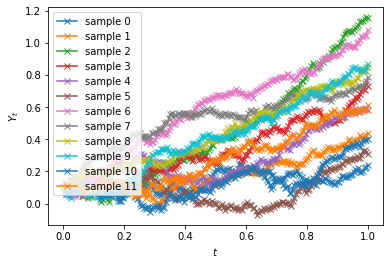

In [9]:
from operator import methodcaller
batch_size, state_size, t_size = 12, 1, 200 #sample 12
sde = SDE()

ts = torch.linspace(0,1,t_size)
y0 = torch.full(size=(batch_size,state_size),fill_value=0.1)

with torch.no_grad():
  ys = torchsde.sdeint(sde, y0, ts, method='euler') #(t_size, batch_size, state_size) = (200,12,1)
plot(ts, ys, xlabel='$t$',ylabel='$Y_t$')

For Itô SDEs method='euler' means the strong order 0.5 **Euler-Maruyama method** is used. Other possible methods include the strong order 1.0 **milstein **and the strong order 1.5 srk, both of which are of slightly higher order. If method is set to None, an appropriate solver would be chosen based on noise_type and sde_type under the hood.

To solve a Stratonovich SDE with drift and diffusion defined above, we need only change sde_type to stratonovich and supply an appropriate method of choice (e.g. the midpoint method):

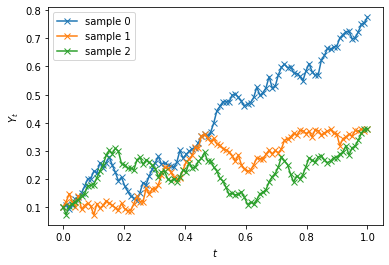

In [10]:
batch_size, state_size, t_size = 3, 1, 100 #sample 12
sde = SDE()

sde.sde_type = "stratonovich"

ts = torch.linspace(0,1,t_size)
y0 = torch.full(size=(batch_size,state_size),fill_value=0.1)

with torch.no_grad():
  ys = torchsde.sdeint(sde, y0, ts, method='midpoint') # (t_size, batch_size, state_size) = (200,3,1)

plot(ts, ys, xlabel='$t$', ylabel='$Y_t$')

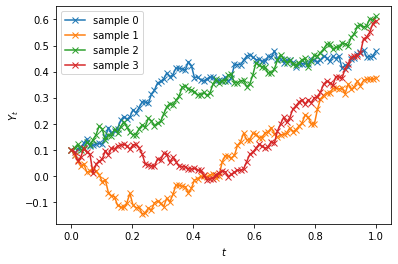

In [16]:
batch_size, state_size, t_size = 4, 1, 100 #sample 12
sde = SDE()

sde.sde_type = "stratonovich"

ts = torch.linspace(0,1,t_size)
y0 = torch.full(size=(batch_size,state_size),fill_value=0.1)

with torch.no_grad():
  ys = torchsde.sdeint(sde, y0, ts, method='euler_heun') # (t_size, batch_size, state_size) = (200,3,1)

plot(ts, ys, xlabel='$t$', ylabel='$Y_t$')

## Other than f and g but still is drift and diffusion functions
For Stratonovich SDEs, the methods `midpoint, euler_heun, heun, milstein, and log_ode` are supported.

The drift and diffusion functions don't necessarily have to be called **f** and **g**. They can be methods with any name, so long as we provide these names to the solver when they differ from the default. The following is an example where **h** is used as the drift.

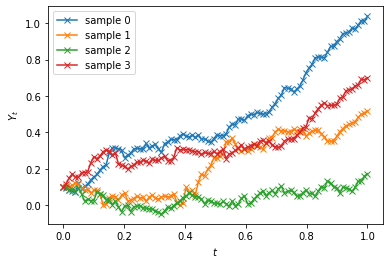

CPU times: user 1.76 s, sys: 14 ms, total: 1.77 s
Wall time: 1.81 s


In [24]:
%%time
class SDE_second(nn.Module):

    def __init__(self):
      super().__init__()
      self.theta = nn.Parameter(torch.tensor(0.1),requires_grad=False)
      self.noise_type = 'diagonal'
      self.sde_type = 'ito'

    def h(self, t, y):
        return torch.sin(t) + self.theta * y
    
    def g(self, t, y):
        return 0.3 * torch.sigmoid(torch.cos(t) * torch.exp(-y))   

sde_second = SDE_second()

with torch.no_grad():
    # Supply a dictionary to the argument `names`.
    ys = torchsde.sdeint(sde_second, y0, ts, method='euler', names={'drift': 'h'})

plot(ts, ys, xlabel='$t$', ylabel='$Y_t$')  

## using GPU
Trivially, the previous code may be adapted to run on GPUs, just by moving all tensors to a GPU:

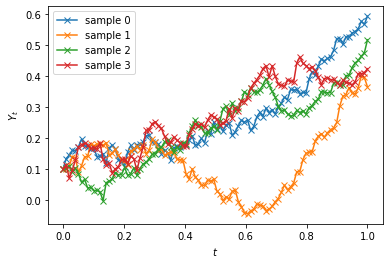

CPU times: user 1.34 s, sys: 6.95 ms, total: 1.35 s
Wall time: 1.35 s


In [22]:
%%time
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
sde_second = SDE_second().to(device)
ts = ts.to(device)
y0 = y0.to(device)

with torch.no_grad():
  ys = torchsde.sdeint(sde_second, y0, ts, method='euler', names={'drift': 'h'})
plot(ts, ys, xlabel='$t$', ylabel='$Y_t$')

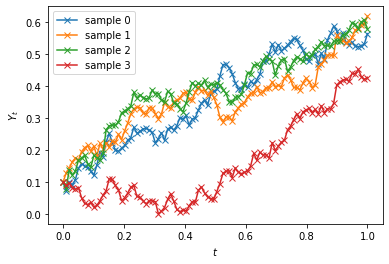

CPU times: user 1.49 s, sys: 12.9 ms, total: 1.5 s
Wall time: 1.52 s


In [25]:
%%time
if torch.cuda.is_available():
    gpu = torch.device('cuda')
    sde = SDE().to(gpu)
    ts = ts.to(gpu)
    y0 = y0.to(gpu)
    with torch.no_grad():
        ys = torchsde.sdeint(sde, y0, ts, method='euler')  # (100, 3, 1).
    
    plot(ts, ys, xlabel='$t$', ylabel='$Y_t$')

# 2. Explicit control over randomness from the Brownian motion
To gain control over the randomness, we draw Brownian motion samples by instantiating objects of classes BrownianInterval.

In [27]:
ts = torch.linspace(0,1,t_size)
bm = torchsde.BrownianInterval(t0=0.0,t1=1.0,size=(batch_size,state_size))

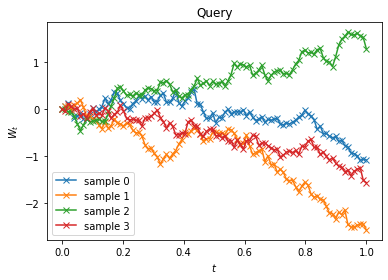

In [28]:
bm_increments = torch.stack([bm(t0, t1) for t0, t1 in zip(ts[:-1], ts[1:])], dim=0) #(99,4,1)
bm_queries = torch.cat((torch.zeros(1, batch_size, state_size), torch.cumsum(bm_increments, dim=0))) (100,4,1)

plot(ts, bm_queries, xlabel='$t$', ylabel='$W_t$', title='Query')

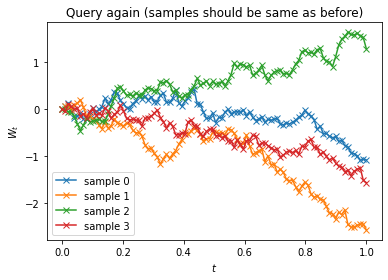

In [31]:
bm_increments2 = torch.stack([bm(t0, t1) for t0, t1 in zip(ts[:-1], ts[1:])], dim=0)
bm_queries2 = torch.cat((torch.zeros(1, batch_size, state_size), torch.cumsum(bm_increments2, dim=0)))
plot(ts, bm_queries, xlabel='$t$', ylabel='$W_t$', 
     title='Query again (samples should be same as before)')

assert torch.allclose(bm_queries, bm_queries2)

In [32]:
#Brownian motion on GPUs by specifying device:

if torch.cuda.is_available():
  bm = torchsde.BrownianInterval(t0=0.0, t1=1.0, size=(batch_size, state_size), device=gpu)
  print(bm(0.0, 0.5))

tensor([[ 0.5256],
        [ 0.2170],
        [-0.0493],
        [-0.2548]], device='cuda:0')


In [26]:
if torch.cuda.is_available():
    bm = torchsde.BrownianInterval(t0=0.0, t1=1.0, size=(batch_size, state_size), device=gpu)
    print(bm(0.0, 0.5))

torch.Size([100])


### Brownian motion can gain control over the randomness better.
Having a Brownian motion object helps us gain control over the randomness better. We can feed the object into the solver such that the solver's solution is conditioned on this path.

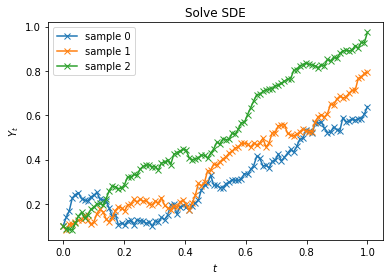

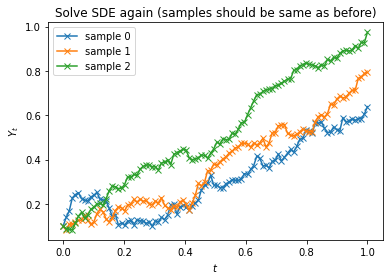

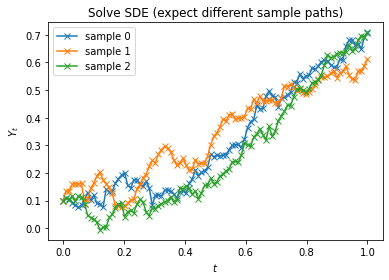

In [11]:
sde = SDE()
ts = torch.linspace(0,1,t_size)
y0 = torch.zeros((batch_size,1)).fill_(0.1) #(batch_size, state_size)
bm = torchsde.BrownianInterval(t0 = 0.0, t1 = 1.0, size = (batch_size, state_size))

with torch.no_grad():
    ys = torchsde.sdeint(sde, y0, ts, method='milstein', bm=bm)
plot(ts, ys, xlabel='$t$', ylabel='$Y_t$', title='Solve SDE')

with torch.no_grad():
    ys = torchsde.sdeint(sde, y0, ts, method='milstein', bm=bm)
plot(ts, ys, xlabel='$t$', ylabel='$Y_t$', 
     title='Solve SDE again (samples should be same as before)')

# Use a new BM sample, we expect different sample paths.
bm = torchsde.BrownianInterval(t0=0.0, t1=1.0, size=(batch_size, state_size))
with torch.no_grad():
    ys = torchsde.sdeint(sde, y0, ts, method='milstein', bm=bm)
plot(ts, ys, xlabel='$t$', ylabel='$Y_t$', 
     title='Solve SDE (expect different sample paths)')

# 3. Noise type of SDEs affects which solvers can be used and what strong orders can be attained
The supported noise types of this codebase are "diagonal", "additive", "scalar", and "general". The following is a simple summary of each type:
- "diagonal": The diffusion function is an elementwise function, whose output has the same size as that of the state (both are of size (batch_size, state_size)). There are state_size independent Brownian motions, each responsible for the noise of only a single state dimension.
- "additive": The diffusion function is constant w.r.t. the state (but not necessarily time). The output of the diffusion function is of size (batch_size, state_size, brownian_size), and the system has brownian_size independent Brownian motions. The integral involving the Brownian motion can be loosely interpreted as integrating a sequence of matrix-vector products.
- "scalar": The diffusion function has output shape (batch_size, state_size, 1 ), and a single Brownian motion is shared across all state dimensions.
- "general": The diffusion function has output shape (batch_size, state_size, brownian_size), and the system has brownian_size independent Brownian motions.

It is tempting to use the noise type configuration "general" for all problems. However, since there's little known structure for these SDEs, solvers with high strong-order cannot be constructed.

Lastly, for modeling problems, our limited experience have found "diagonal" to be a good setting, where flexibility of models and tractability of numerical integration is rather well-balanced.

# 4. Computing gradients
Computing gradients through SDE solutions can be easily done by calling the `backward` function on loss tensors, or using `torch.autograd.grad` :

In [12]:
ys = torchsde.sdeint(sde, y0, ts, method='euler', bm=bm)
y_final = ys[-1]
target = torch.randn_like(y_final)
loss = ((target - y_final)**2).sum(dim=1).mean(dim=0)
loss.backward()
print(sde.theta.grad) 

tensor(0.7667)


In [16]:
sde.theta.grad.item()

0.7667031288146973

In [19]:
ys = torchsde.sdeint(sde, y0, ts, method='euler', bm=bm)
y_final = ys[-1]
target = torch.randn_like(y_final)
loss = ((target - y_final) ** 2).sum(dim=1).mean(dim=0)

grad,= torch.autograd.grad(loss, sde.theta)
print(grad)

tensor(-0.2655)


Switching to adjoint-mode gradient computation is as simple as replacing sdeint with sdeint_adjoint

In [ ]:
ys = torchsde.sdeint_adjoint(sde, y0, ts, method='euler', bm=bm)
y_final = ys[-1]
target = torch.randn_like(y_final)
loss = ((target - y_final) ** 2).sum(dim=1).mean(dim=0)

In [20]:
ys = torchsde.sdeint_adjoint(sde, y0, ts, method='euler', bm=bm)
y_final = ys[-1]
target = torch.randn_like(y_final)
loss = ((target - y_final) ** 2).sum(dim=1).mean(dim=0)
loss.backward()
print(sde.theta.grad)

tensor(0.7702)


# Neural network 

In [38]:
import torch
import torchsde

batch_size, state_size, brownian_size = 32, 3, 2
t_size = 20

class SDE(torch.nn.Module):
    noise_type = 'general'
    sde_type = 'ito'

    def __init__(self):
        super().__init__()
        self.mu = torch.nn.Linear(state_size, 
                                  state_size)
        self.sigma = torch.nn.Linear(state_size, 
                                     state_size * brownian_size)

    # Drift
    def f(self, t, y):
        return self.mu(y)  # shape (batch_size, state_size)

    # Diffusion
    def g(self, t, y):
        return self.sigma(y).view(batch_size, 
                                  state_size, 
                                  brownian_size)

sde = SDE()
y0 = torch.full((batch_size, state_size), 0.1)
ts = torch.linspace(0, 1, t_size)
# Initial state y0, the SDE is solved over the interval [ts[0], ts[-1]].
# ys will have shape (t_size, batch_size, state_size)
ys = torchsde.sdeint(sde, y0, ts)

In [39]:
y_final = ys[-1]
target = torch.randn_like(y_final)
loss = ((target - y_final) ** 2).sum(dim=1).mean(dim=0)

loss.backward()

In [64]:
"""Latent SDE fit to a single time series with uncertainty quantification."""
import argparse
import logging
import math
import os
import random
from collections import namedtuple
from typing import Optional, Union

import matplotlib.pyplot as plt
import numpy as np
import torch
import tqdm
from torch import distributions, nn, optim

import torchsde

# w/ underscore -> numpy; w/o underscore -> torch.
Data = namedtuple('Data', ['ts_', 'ts_ext_', 'ts_vis_', 'ts', 'ts_ext', 'ts_vis', 'ys', 'ys_'])


class LinearScheduler(object):
    def __init__(self, iters, maxval=1.0):
        self._iters = max(1, iters)
        self._val = maxval / self._iters
        self._maxval = maxval

    def step(self):
        self._val = min(self._maxval, self._val + self._maxval / self._iters)

    @property
    def val(self):
        return self._val


class EMAMetric(object):
    def __init__(self, gamma: Optional[float] = .99):
        super(EMAMetric, self).__init__()
        self._val = 0.
        self._gamma = gamma

    def step(self, x: Union[torch.Tensor, np.ndarray]):
        x = x.detach().cpu().numpy() if torch.is_tensor(x) else x
        self._val = self._gamma * self._val + (1 - self._gamma) * x
        return self._val

    @property
    def val(self):
        return self._val


def str2bool(v):
    """Used for boolean arguments in argparse; avoiding `store_true` and `store_false`."""
    if isinstance(v, bool): return v
    if v.lower() in ('yes', 'true', 't', 'y', '1'): return True
    elif v.lower() in ('no', 'false', 'f', 'n', '0'): return False
    else: raise argparse.ArgumentTypeError('Boolean value expected.')


def manual_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


def _stable_division(a, b, epsilon=1e-7):
    b = torch.where(b.abs().detach() > epsilon, b, torch.full_like(b, fill_value=epsilon) * b.sign())
    return a / b


class LatentSDE(torchsde.SDEIto):

    def __init__(self, theta=1.0, mu=0.0, sigma=0.5):
        super(LatentSDE, self).__init__(noise_type="diagonal")
        logvar = math.log(sigma ** 2 / (2. * theta))

        # Prior drift.
        self.register_buffer("theta", torch.tensor([[theta]]))
        self.register_buffer("mu", torch.tensor([[mu]]))
        self.register_buffer("sigma", torch.tensor([[sigma]]))

        # p(y0).
        self.register_buffer("py0_mean", torch.tensor([[mu]]))
        self.register_buffer("py0_logvar", torch.tensor([[logvar]]))

        # Approximate posterior drift: Takes in 2 positional encodings and the state.
        self.net = nn.Sequential(
            nn.Linear(3, 200),
            nn.Tanh(),
            nn.Linear(200, 200),
            nn.Tanh(),
            nn.Linear(200, 1)
        )
        # Initialization trick from Glow.
        self.net[-1].weight.data.fill_(0.)
        self.net[-1].bias.data.fill_(0.)

        # q(y0).
        self.qy0_mean = nn.Parameter(torch.tensor([[mu]]), requires_grad=True)
        self.qy0_logvar = nn.Parameter(torch.tensor([[logvar]]), requires_grad=True)

    def f(self, t, y):  # Approximate posterior drift.
        if t.dim() == 0:
            t = torch.full_like(y, fill_value=t)
        # Positional encoding in transformers for time-inhomogeneous posterior.
        return self.net(torch.cat((torch.sin(t), torch.cos(t), y), dim=-1))

    def g(self, t, y):  # Shared diffusion.
        return self.sigma.repeat(y.size(0), 1)

    def h(self, t, y):  # Prior drift.
        return self.theta * (self.mu - y)

    def f_aug(self, t, y):  # Drift for augmented dynamics with logqp term.
        y = y[:, 0:1]
        f, g, h = self.f(t, y), self.g(t, y), self.h(t, y)
        u = _stable_division(f - h, g)
        f_logqp = .5 * (u ** 2).sum(dim=1, keepdim=True)
        return torch.cat([f, f_logqp], dim=1)

    def g_aug(self, t, y):  # Diffusion for augmented dynamics with logqp term.
        y = y[:, 0:1]
        g = self.g(t, y)
        g_logqp = torch.zeros_like(y)
        return torch.cat([g, g_logqp], dim=1)

    def forward(self, ts, batch_size, eps=None):
        eps = torch.randn(batch_size, 1).to(self.qy0_std) if eps is None else eps
        y0 = self.qy0_mean + eps * self.qy0_std
        qy0 = distributions.Normal(loc=self.qy0_mean, scale=self.qy0_std)
        py0 = distributions.Normal(loc=self.py0_mean, scale=self.py0_std)
        logqp0 = distributions.kl_divergence(qy0, py0).sum(dim=1)  # KL(t=0).

        aug_y0 = torch.cat([y0, torch.zeros(batch_size, 1).to(y0)], dim=1)
        aug_ys = sdeint_fn(
            sde=self,
            y0=aug_y0,
            ts=ts,
            method=args.method,
            dt=args.dt,
            adaptive=args.adaptive,
            rtol=args.rtol,
            atol=args.atol,
            names={'drift': 'f_aug', 'diffusion': 'g_aug'}
        )
        ys, logqp_path = aug_ys[:, :, 0:1], aug_ys[-1, :, 1]
        logqp = (logqp0 + logqp_path).mean(dim=0)  # KL(t=0) + KL(path).
        return ys, logqp

    def sample_p(self, ts, batch_size, eps=None, bm=None):
        eps = torch.randn(batch_size, 1).to(self.py0_mean) if eps is None else eps
        y0 = self.py0_mean + eps * self.py0_std
        return sdeint_fn(self, y0, ts, bm=bm, method='srk', dt=args.dt, names={'drift': 'h'})

    def sample_q(self, ts, batch_size, eps=None, bm=None):
        eps = torch.randn(batch_size, 1).to(self.qy0_mean) if eps is None else eps
        y0 = self.qy0_mean + eps * self.qy0_std
        return sdeint_fn(self, y0, ts, bm=bm, method='srk', dt=args.dt)

    @property
    def py0_std(self):
        return torch.exp(.5 * self.py0_logvar)

    @property
    def qy0_std(self):
        return torch.exp(.5 * self.qy0_logvar)


def make_segmented_cosine_data():
    ts_ = np.concatenate((np.linspace(0.3, 0.8, 10), np.linspace(1.2, 1.5, 10)), axis=0)
    ts_ext_ = np.array([0.] + list(ts_) + [2.0])
    ts_vis_ = np.linspace(0., 2.0, 300)
    ys_ = np.cos(ts_ * (2. * math.pi))[:, None]

    ts = torch.tensor(ts_).float()
    ts_ext = torch.tensor(ts_ext_).float()
    ts_vis = torch.tensor(ts_vis_).float()
    ys = torch.tensor(ys_).float().to(device)
    return Data(ts_, ts_ext_, ts_vis_, ts, ts_ext, ts_vis, ys, ys_)


def make_irregular_sine_data():
    ts_ = np.sort(np.random.uniform(low=0.4, high=1.6, size=16))
    ts_ext_ = np.array([0.] + list(ts_) + [2.0])
    ts_vis_ = np.linspace(0., 2.0, 300)
    ys_ = np.sin(ts_ * (2. * math.pi))[:, None] * 0.8

    ts = torch.tensor(ts_).float()
    ts_ext = torch.tensor(ts_ext_).float()
    ts_vis = torch.tensor(ts_vis_).float()
    ys = torch.tensor(ys_).float().to(device)
    return Data(ts_, ts_ext_, ts_vis_, ts, ts_ext, ts_vis, ys, ys_)


def make_data():
    data_constructor = {
        'segmented_cosine': make_segmented_cosine_data,
        'irregular_sine': make_irregular_sine_data
    }[args.data]
    return data_constructor()

def main():
    # Dataset.
    ts_, ts_ext_, ts_vis_, ts, ts_ext, ts_vis, ys, ys_ = make_data()

    # Plotting parameters.
    vis_batch_size = 1024
    ylims = (-1.75, 1.75)
    alphas = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55]
    percentiles = [0.999, 0.99, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
    vis_idx = np.random.permutation(vis_batch_size)
    # From https://colorbrewer2.org/.
    if args.color == "blue":
        sample_colors = ('#8c96c6', '#8c6bb1', '#810f7c')
        fill_color = '#9ebcda'
        mean_color = '#4d004b'
        num_samples = len(sample_colors)
    else:
        sample_colors = ('#fc4e2a', '#e31a1c', '#bd0026')
        fill_color = '#fd8d3c'
        mean_color = '#800026'
        num_samples = len(sample_colors)

    eps = torch.randn(vis_batch_size, 1).to(device)  # Fix seed for the random draws used in the plots.
    bm = torchsde.BrownianInterval(
        t0=ts_vis[0],
        t1=ts_vis[-1],
        size=(vis_batch_size, 1),
        device=device,
        levy_area_approximation='space-time'
    )  # We need space-time Levy area to use the SRK solver

    # Model.
    model = LatentSDE().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-2)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=.999)
    kl_scheduler = LinearScheduler(iters=args.kl_anneal_iters)

    logpy_metric = EMAMetric()
    kl_metric = EMAMetric()
    loss_metric = EMAMetric()

    if args.show_prior:
        with torch.no_grad():
            zs = model.sample_p(ts=ts_vis, batch_size=vis_batch_size, eps=eps, bm=bm).squeeze()
            ts_vis_, zs_ = ts_vis.cpu().numpy(), zs.cpu().numpy()
            zs_ = np.sort(zs_, axis=1)

            img_dir = os.path.join(args.train_dir, 'prior.png')
            plt.subplot(frameon=False)
            for alpha, percentile in zip(alphas, percentiles):
                idx = int((1 - percentile) / 2. * vis_batch_size)
                zs_bot_ = zs_[:, idx]
                zs_top_ = zs_[:, -idx]
                plt.fill_between(ts_vis_, zs_bot_, zs_top_, alpha=alpha, color=fill_color)

            # `zorder` determines who's on top; the larger the more at the top.
            plt.scatter(ts_, ys_, marker='x', zorder=3, color='k', s=35)  # Data.
            plt.ylim(ylims)
            plt.xlabel('$t$')
            plt.ylabel('$Y_t$')
            plt.tight_layout()
            plt.savefig(img_dir, dpi=args.dpi)
            plt.close()
            logging.info(f'Saved prior figure at: {img_dir}')

    for global_step in tqdm.tqdm(range(args.train_iters)):
        # Plot and save.
        if global_step % args.pause_iters == 0:
            img_path = os.path.join(args.train_dir, f'global_step_{global_step}.png')

            with torch.no_grad():
                zs = model.sample_q(ts=ts_vis, batch_size=vis_batch_size, eps=eps, bm=bm).squeeze()
                samples = zs[:, vis_idx]
                ts_vis_, zs_, samples_ = ts_vis.cpu().numpy(), zs.cpu().numpy(), samples.cpu().numpy()
                zs_ = np.sort(zs_, axis=1)
                plt.subplot(frameon=False)

                if args.show_percentiles:
                    for alpha, percentile in zip(alphas, percentiles):
                        idx = int((1 - percentile) / 2. * vis_batch_size)
                        zs_bot_, zs_top_ = zs_[:, idx], zs_[:, -idx]
                        plt.fill_between(ts_vis_, zs_bot_, zs_top_, alpha=alpha, color=fill_color)

                if args.show_mean:
                    plt.plot(ts_vis_, zs_.mean(axis=1), color=mean_color)

                if args.show_samples:
                    for j in range(num_samples):
                        plt.plot(ts_vis_, samples_[:, j], color=sample_colors[j], linewidth=1.0)

                if args.show_arrows:
                    num, dt = 12, 0.12
                    t, y = torch.meshgrid(
                        [torch.linspace(0.2, 1.8, num).to(device), torch.linspace(-1.5, 1.5, num).to(device)]
                    )
                    t, y = t.reshape(-1, 1), y.reshape(-1, 1)
                    fty = model.f(t=t, y=y).reshape(num, num)
                    dt = torch.zeros(num, num).fill_(dt).to(device)
                    dy = fty * dt
                    dt_, dy_, t_, y_ = dt.cpu().numpy(), dy.cpu().numpy(), t.cpu().numpy(), y.cpu().numpy()
                    plt.quiver(t_, y_, dt_, dy_, alpha=0.3, edgecolors='k', width=0.0035, scale=50)

                if args.hide_ticks:
                    plt.xticks([], [])
                    plt.yticks([], [])

                plt.scatter(ts_, ys_, marker='x', zorder=3, color='k', s=35)  # Data.
                plt.ylim(ylims)
                plt.xlabel('$t$')
                plt.ylabel('$Y_t$')
                plt.tight_layout()
                plt.savefig(img_path, dpi=args.dpi)
                plt.close()
                logging.info(f'Saved figure at: {img_path}')

                if args.save_ckpt:
                    torch.save(
                        {'model': model.state_dict(),
                         'optimizer': optimizer.state_dict(),
                         'scheduler': scheduler.state_dict(),
                         'kl_scheduler': kl_scheduler},
                        os.path.join(ckpt_dir, f'global_step_{global_step}.ckpt')
                    )

        # Train.
        optimizer.zero_grad()
        zs, kl = model(ts=ts_ext, batch_size=args.batch_size)
        zs = zs.squeeze()
        zs = zs[1:-1]  # Drop first and last which are only used to penalize out-of-data region and spread uncertainty.

        likelihood_constructor = {"laplace": distributions.Laplace, "normal": distributions.Normal}[args.likelihood]
        likelihood = likelihood_constructor(loc=zs, scale=args.scale)
        logpy = likelihood.log_prob(ys).sum(dim=0).mean(dim=0)

        loss = -logpy + kl * kl_scheduler.val
        loss.backward()

        optimizer.step()
        scheduler.step()
        kl_scheduler.step()

        logpy_metric.step(logpy)
        kl_metric.step(kl)
        loss_metric.step(loss)

        logging.info(
            f'global_step: {global_step}, '
            f'logpy: {logpy_metric.val:.3f}, '
            f'kl: {kl_metric.val:.3f}, '
            f'loss: {loss_metric.val:.3f}'
        )



### Make data

#### make_segmented_cosine_data

In [44]:
ts_ = np.concatenate((np.linspace(0.3, 0.8, 10), np.linspace(1.2, 1.5, 10)), axis=0) #(20,)
ts_ext_ = np.array([0.] + list(ts_) + [2.0]) #(22,)
ts_vis_ = np.linspace(0., 2.0, 300) #300
ys_ = np.cos(ts_ * (2. * math.pi))[:, None] #(20,1)

ts = torch.tensor(ts_).float()
ts_ext = torch.tensor(ts_ext_).float()
ts_vis = torch.tensor(ts_vis_).float()
ys = torch.tensor(ys_).float()  #(20,1)


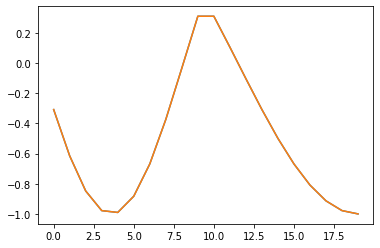

In [47]:
plt.plot(ys_)

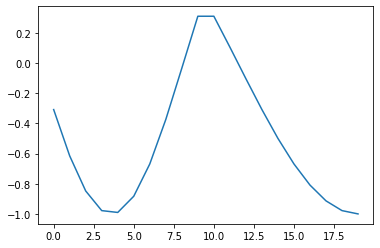

In [48]:
plt.plot(ys)

### Make data

#### make_irregular_sine_data

In [49]:
ts_ = np.sort(np.random.uniform(low=0.4, high=1.6, size=16))
ts_ext_ = np.array([0.] + list(ts_) + [2.0])
ts_vis_ = np.linspace(0., 2.0, 300)
ys_ = np.sin(ts_ * (2. * math.pi))[:, None] * 0.8

ts = torch.tensor(ts_).float()
ts_ext = torch.tensor(ts_ext_).float()
ts_vis = torch.tensor(ts_vis_).float()
ys = torch.tensor(ys_).float()

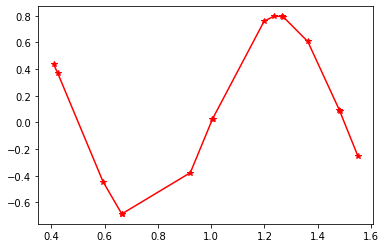

In [62]:
plt.plot(ts_,ys_,'*-',color='red')

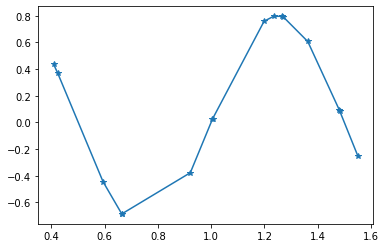

In [60]:
plt.plot(ts,ys,'*-')

In [73]:
%cd torchsde/

/content/torchsde


In [74]:
! python -m examples.latent_sde --train-dir /content/sample_data

  0% 0/5000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100% 5000/5000 [34:14<00:00,  2.43it/s]
